In [513]:
#imports
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker
from colorama import Fore

In [514]:
#read files
data = pd.read_csv('/datasets/games.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [515]:
data.head(20)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


## Preprocessing

In [516]:
#converting columns names to lowercase
data.columns = data.columns.str.lower()
#data.columns

In [517]:
#converting year_of_release from float to time period
data['year_of_release'] = pd.to_datetime(data['year_of_release'], format='%Y').dt.to_period('Y')
#data['year_of_release'].unique()

In [518]:
data['user_score'].isna().sum()/data['user_score'].shape[0]

0.4008973975471134

In [519]:
data.query('user_score == "tbd"')['user_score'].count()/data['user_score'].shape[0]

0.1450194436135208

In [520]:
#converting user_score "tbd" and NaN to meaningless numbers
data['user_score'].replace('tbd',-100,inplace=True)
data['user_score'] = data['user_score'].fillna(-200)
#data['user_score'].unique()

In [521]:
#converting user_score from object to float
data['user_score'] = pd.to_numeric(data['user_score'])

user_score :

40% of data is NaN, 15% is "tbd", with this volume there's no reliable way to recover the missing values. We can fill them with meaningless numerical values to enable convertion to float.

Reason for missing values: users chose not to fill.
Type: MCAR

In [522]:
data.loc[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,-200.0,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,-200.0,NaN


In [523]:
data.query('(year_of_release == 1993) and (platform=="GEN")')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,-200.0,NaN
7885,Shining Force II,GEN,1993,Strategy,0.00,0.00,0.19,0.00,NaN,-200.0,NaN
8893,Super Street Fighter II,GEN,1993,Fighting,0.00,0.00,0.15,0.00,NaN,-200.0,NaN
11986,Ecco: The Tides of Time,GEN,1993,Adventure,0.00,0.00,0.07,0.00,NaN,-200.0,NaN
12098,Street Fighter II': Special Champion Edition (...,GEN,1993,Action,0.00,0.00,0.07,0.00,NaN,-200.0,NaN
12264,Streets of Rage 3,GEN,1993,Action,0.00,0.00,0.07,0.00,NaN,-200.0,NaN
12984,Dynamite Headdy,GEN,1993,Platform,0.00,0.00,0.05,0.00,NaN,-200.0,NaN
13343,Beyond Oasis,GEN,1993,Role-Playing,0.00,0.00,0.05,0.00,NaN,-200.0,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,-200.0,NaN


In [524]:
data.dropna(subset=['name','genre'],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null period[A-DEC]
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         16713 non-null float64
rating             9949 non-null object
dtypes: float64(6), object(4), period[A-DEC](1)
memory usage: 1.5+ MB


name, genre :

only 2 missing values with very little information, we can drop them

In [525]:
data.loc[data['year_of_release'].isna(),:]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaT,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaT,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaT,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaT,Fighting,1.57,1.02,0.00,0.41,NaN,-200.0,NaN
609,Space Invaders,2600,NaT,Shooter,2.36,0.14,0.00,0.03,NaN,-200.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaT,Sports,0.01,0.00,0.00,0.00,43.0,-100.0,E10+
16405,Freaky Flyers,GC,NaT,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaT,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaT,Adventure,0.01,0.00,0.00,0.00,NaN,-200.0,NaN


yaer_of_release :

269 missing values, they can be recovered by manual web research. Left them NaT.

Reason for missing values: the data was probably collected by an automatic system and the year wasn't specified in the expected field or at all.
Type: MCAR

In [526]:
#checking correlation between columns
data.corr()

,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
na_sales,1.000000,0.765341,0.449668,0.638695,0.240755,0.111132
eu_sales,0.765341,1.000000,0.435079,0.722796,0.220752,0.125944
jp_sales,0.449668,0.435079,1.000000,0.291090,0.152593,-0.094991
other_sales,0.638695,0.722796,0.291090,1.000000,0.198554,0.143775
critic_score,0.240755,0.220752,0.152593,0.198554,1.000000,0.239702
user_score,0.111132,0.125944,-0.094991,0.143775,0.239702,1.000000


In [527]:
#filling missing values in critic_score and converting to int
data['critic_score'] = data['critic_score'].fillna(-200)
data['critic_score'] = data['critic_score'].astype('int64')
#data['critic_score'].unique()

critic_score :

Almost 50% missing values and moderate correlation to other columns, no reliable way to recover. We can fill NaNs with meaningless numerical value and then convert to int64 since all values are integers.

Reason for missing values: these games weren't evaluated or their score wasn't available
Type: MAR

In [528]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [529]:
#creating rating categories interpreter
esrb = {'E' : 'everyone',
       'M' : 'mature',
       'T': 'teens',
       'E10+' : 'everyone 10+',
       'AO' : 'adults only',
       'EC' : 'early childhood',
       'RP' : 'rating pending'}
#replacing 'K-A' (kids-adults) with the updated category 'E' 
data['rating'].replace('K-A','E',inplace=True)

In [530]:
data['rating'] = data['rating'].fillna('N/A')
data['rating'].value_counts()

N/A     6764
E       3993
T       2961
M       1563
E10+    1420
EC         8
RP         3
AO         1
Name: rating, dtype: int64

rating : 
 
First we should replaced 'K-A' (kids-adults) with the updated category 'E' according to esrb website "This rating was known as Kids to Adults (K-A) until 1998, when it was renamed "Everyone"."
Missing values (about 50% of data) may be recoverble by manual research, we can fill them with 'N/A'.

Reason for missing values: these games weren't rated by esrb or their rating was no longer available.
Type: MAR

In [531]:
#searching duplicate typos in platform
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [532]:
#searching duplicate typos in platform#searching duplicate typos in genre
data['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

#### Adding Calculations

In [533]:
#calculating the total sales accros na, eu, jp, other 
data['total_sales'] = data['na_sales'].add(data['eu_sales'], fill_value=0) \
    .add(data['jp_sales'], fill_value=0) \
    .add(data['other_sales'], fill_value=0)
data['total_sales'].head()

0    82.54
1    40.24
2    35.52
3    32.77
4    31.38
Name: total_sales, dtype: float64

## Analysis

In [534]:
#releases by year 
stat = {}
stat['releases_by_year'] = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
stat['releases_by_year'].columns = ['number_of_games']
stat['releases_by_year']

,number_of_games
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


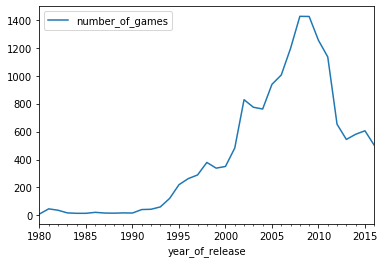

In [535]:
stat['releases_by_year'].plot()

Until the year of 1994 the number of releases was not significant, probably due to small availability of PCs.
Releases are increasing almost continiously from 1994 to 2008 - the year of financial crisis, and then almost continueously decreasing until 2016 with similar rate.

In [536]:
#Total sales by platform
stat['total_sales_by_platform'] = data.query('year_of_release >= 1994') \
    .pivot_table(index='platform', values='total_sales', aggfunc='sum') \
    .sort_values(by='total_sales', ascending=False)
stat['total_sales_by_platform'].columns = ['total_sales']
#stat['total_sales_by_platform']

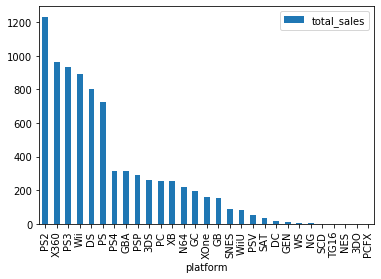

In [537]:
stat['total_sales_by_platform'].plot.bar()

In [538]:
stat['total_sales_by_platform'].loc['PS']

total_sales    727.58
Name: PS, dtype: float64

In [539]:
#getting platforms with greatest sales
platforms_max_sales = list(stat['total_sales_by_platform'].query('total_sales >= 600').index)
platforms_max_sales

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

In [540]:
#building distributions by year of release for each
stat['platforms_total_sales_by_year'] = pd.DataFrame()
#index=pd.DataFrame(sorted(list(data['year_of_release'].dropna().unique())))
for platform in platforms_max_sales:
    sales_of_platform = data.loc[(data['platform']==platform) & (data['year_of_release']>=1994),:] \
        .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum') 
    sales_of_platform.columns = [platform + '_total_sales']
    stat['platforms_total_sales_by_year'] = stat['platforms_total_sales_by_year'] \
        .merge(sales_of_platform, left_index=True, right_index=True, how='outer') 
    

stat['platforms_total_sales_by_year']   

,PS2_total_sales,X360_total_sales,PS3_total_sales,Wii_total_sales,DS_total_sales,PS_total_sales
year_of_release,,,,,,
1994,NaN,NaN,NaN,NaN,NaN,6.03
1995,NaN,NaN,NaN,NaN,NaN,35.96
1996,NaN,NaN,NaN,NaN,NaN,94.70
1997,NaN,NaN,NaN,NaN,NaN,136.17
1998,NaN,NaN,NaN,NaN,NaN,169.49
1999,NaN,NaN,NaN,NaN,NaN,144.53
2000,39.17,NaN,NaN,NaN,NaN,96.37
2001,166.43,NaN,NaN,NaN,NaN,35.59
2002,205.38,NaN,NaN,NaN,NaN,6.67


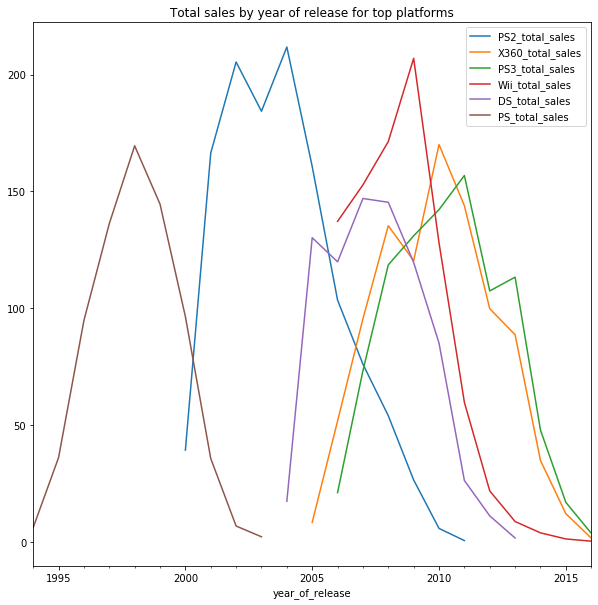

In [541]:
#plotting total sales by year of release per selected platform
ax = stat['platforms_total_sales_by_year'].plot( \
                                                title='Total sales by year of release for top platforms',
                                               figsize=(10,10))

The platforms PS, PS2, DS used to be popular with high sales but are no longer used today.
Wii, X360, PS3 are also reaching there.
It looks like a platform "live" for about 10 years. In the years of 2005-2006 new platforms appear simultanously and their rising and falling seems correlated. 
It looks like the first group follows one pattern between the years 1994-2013 when new platform appears about 5 years after the previous one. The second group follows a different pattern between the years 2005-2016.
It is interesting to note that when looking at the top 6, no new platform appears until 2016 although the previous ones have been fading for some time. According to the first pattern one might expect a new platform to appear around 2011 so we need to further exmine the rest of platforms in recent years.

To build a prognosis for 2017:

the "living period" of a platform is about 10-11 years. But it's actually enough to investigate the current platforms only in the past 5 years because after 5 years the leading platforms begin to fall the new ones take over.
It's also better to look at years after 2009 when the release graph begin do decrease.
In order to forecast 2017 it's enough to look at 2012-2016. In this period we'll need to investigate more of the other platforms as well (that have lower sales because they are still new maybe)

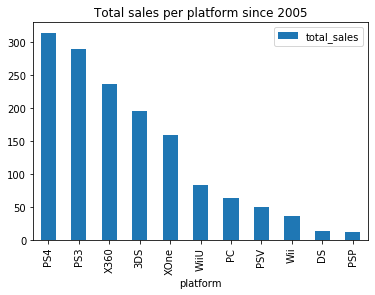

In [542]:
#getting relevant platforms in 2005-2016
relevant_mask = data.eval('year_of_release >=2012')
stat['total_sales_by_platform_new'] = data.loc[relevant_mask,:] \
    .pivot_table(index='platform', values='total_sales', aggfunc='sum') \
    .sort_values(by='total_sales', ascending=False)
stat['total_sales_by_platform_new'].columns = ['total_sales']
stat['total_sales_by_platform_new'].plot.bar(title='Total sales per platform since 2005')

In [543]:
stat['total_sales_by_platform_new'].loc['XOne']

total_sales    159.32
Name: XOne, dtype: float64

In [544]:
platforms_new = list(stat['total_sales_by_platform_new'].index)

#building distributions by year of release for each
stat['platforms_total_sales_by_year_new'] = \
    stat['platforms_total_sales_by_year'].query('year_of_release>=2012').dropna(axis=1,how='all')

for platform in list(set(platforms_new)-set(platforms_max_sales)):
    sales_of_platform = data.loc[(relevant_mask) & (data['platform']==platform),:] \
        .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum') 
    sales_of_platform.columns = [platform + '_total_sales']
    stat['platforms_total_sales_by_year_new'] = stat['platforms_total_sales_by_year_new'] \
        .merge(sales_of_platform, left_index=True, right_index=True, how='outer') 
    
#stat['platforms_total_sales_by_year_new'] 

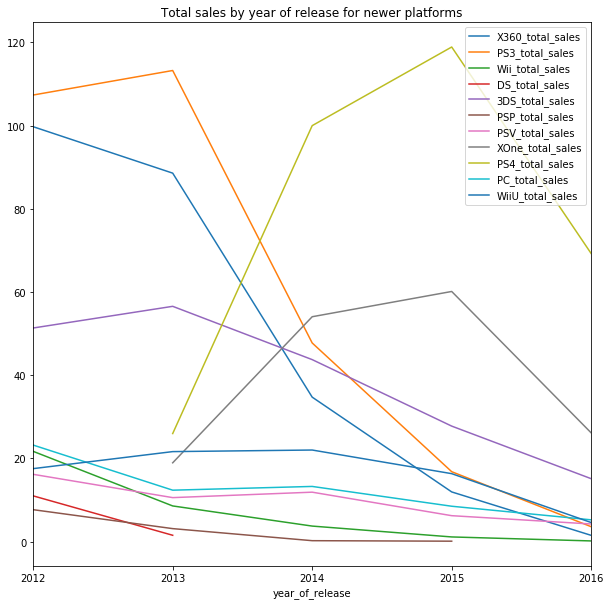

In [545]:
#plotting total sales by year of release per selected platform
ax = stat['platforms_total_sales_by_year_new'].plot( \
                                                title='Total sales by year of release for newer platforms',
                                               figsize=(10,10))

The plot shows we can ignore Wii,DS,PC,WiiU,PSP,PSV that have minor sales (left to XOne in the bar plot)

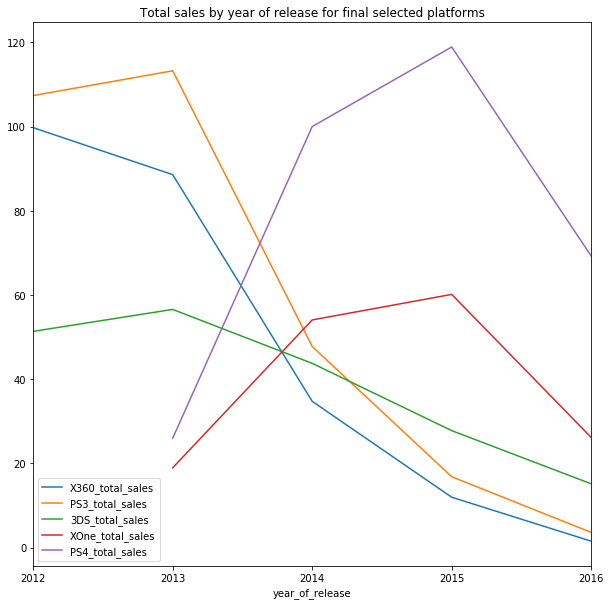

In [546]:
platforms_new =  list(stat['total_sales_by_platform_new'].query('total_sales>158').index)
#plotting total sales by year of release for final platforms
stat['platforms_total_sales_by_year_new'] = stat['platforms_total_sales_by_year_new'] \
    .drop(columns=['PSP_total_sales', 'PC_total_sales','Wii_total_sales', \
                   'DS_total_sales', 'WiiU_total_sales','PSV_total_sales'])
ax = stat['platforms_total_sales_by_year_new'].plot( \
                                                title='Total sales by year of release for final selected platforms',
                                               figsize=(10,10))

The plaforms that lead the sales in the last decade (X360 and PS3) almost fade by 2016, as well as 3DS. New platforms appear at 2013 - XOne and PS4 leading the sales but they also in decrease by 2016. It looks like a new platform should appear in the coming 2 years.

In [547]:
#getting the platforms in the correct order
platforms_new=list(data.loc[(relevant_mask)& (data['platform'].isin(platforms_new)),'platform'].unique())

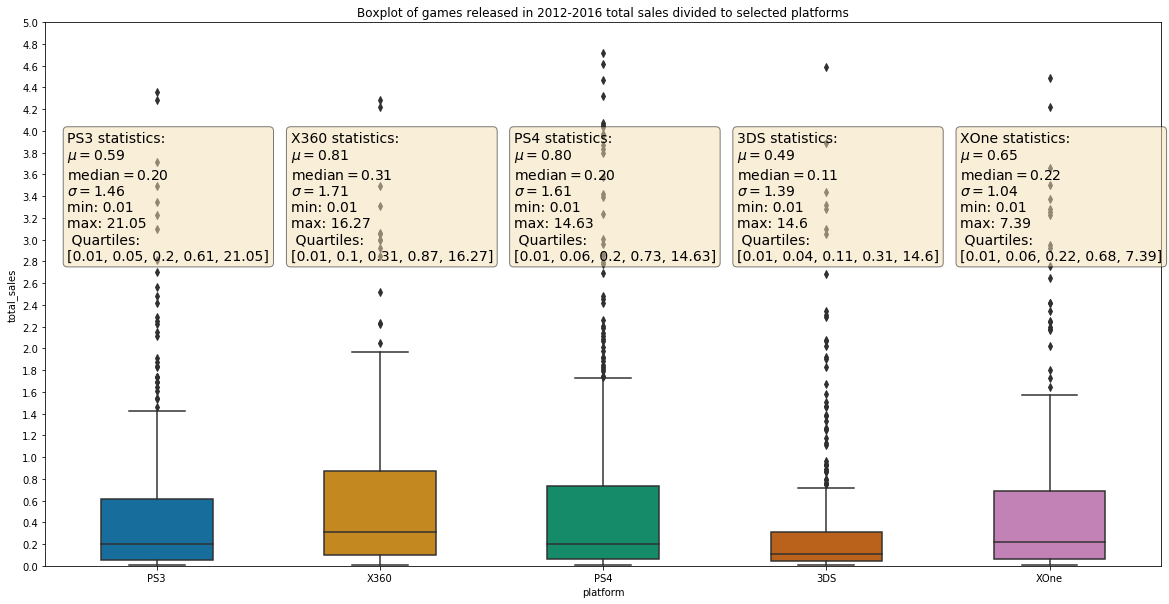

In [548]:
#boxplotting games total sales per selected platform

fig, ax = plt.subplots(figsize=(20,10))
plt.title('Boxplot of games released in 2012-2016 total sales divided to selected platforms')
sns.boxplot(y='total_sales',x='platform',data=data.loc[(relevant_mask) & (data['platform'].isin(platforms_new))], \
           width=0.5, palette="colorblind", ax=ax)
ax.set_ylim(0,5)
#set y precision to 0.2
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.2))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
i=0
for platform in platforms_new:
    #calculating statistics
    mean = data.loc[(relevant_mask) & (data['platform']==platform),'total_sales'].mean()
    median = data.loc[(relevant_mask) & (data['platform']==platform),'total_sales'].median()
    std = data.loc[(relevant_mask) & (data['platform']==platform),'total_sales'].std()
    minval =  round(data.loc[(relevant_mask) & (data['platform']==platform),'total_sales'].min(),2)
    maxval = round(data.loc[(relevant_mask) & (data['platform']==platform),'total_sales'].max(),2)
    #adding quartiles
    quartiles = pd.qcut(data.loc[(relevant_mask) & (data['platform']==platform),'total_sales'], \
                        4,retbins=True,duplicates='drop',precision=2)
    for q in range(len(quartiles[1])):
        quartiles[1][q]=round(quartiles[1][q],2)
    #creating the text for textbox
    textstr = '\n'.join((
        platform+' statistics:\n'
        r'$\mu=%.2f$' % (mean, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\sigma=%.2f$' % (std, ),
        'min: '+str(minval),
        'max: '+str(maxval),
        ' Quartiles:',str(list(quartiles[1]))))
    # place a text box 
    fig.text(0.02+0.2*i, 0.8, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    i+=1

- All platforms above have IQR of less than 1M USD, the smallest is 3DS with IQR of about 250000, the largest is X360 with IQR 850000
- All medians are around 200000 USD, 3DS with lowest (110000) and X360 with largest (310000)
- Average sales are between 500000-800000
- Maximun sales reach 8-20 M, meaning most of the range is outliers according to IQR method 

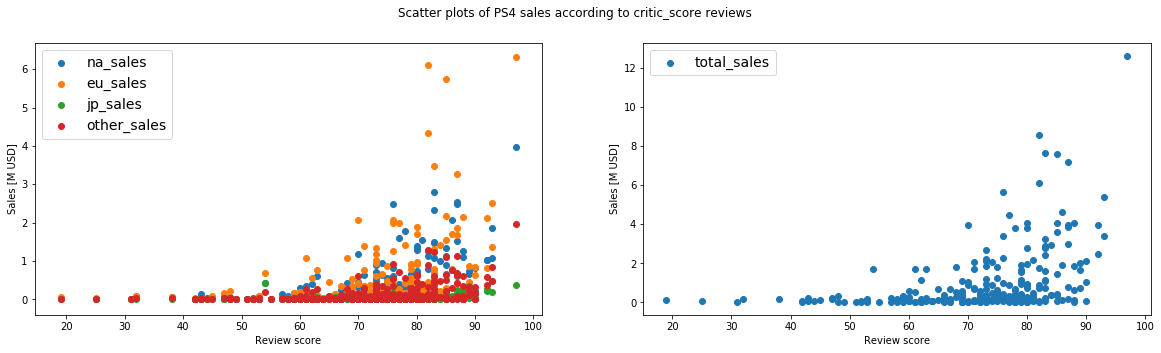

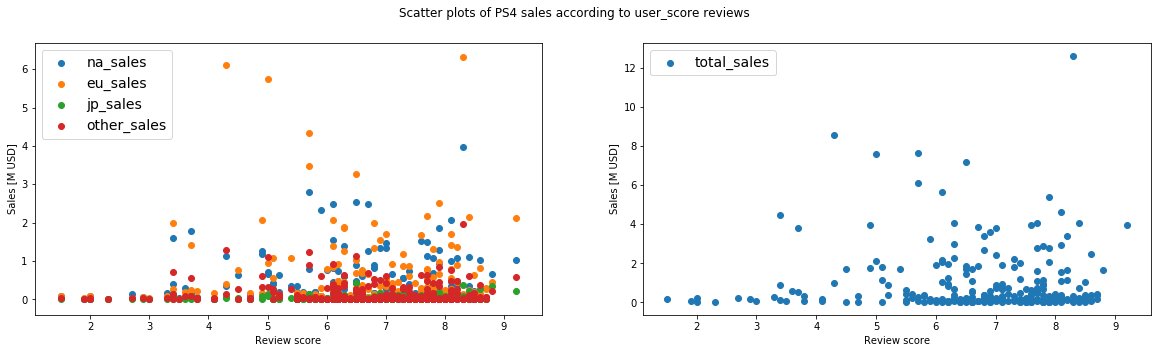

In [549]:
#scatter plotting PS4 sales according to user and professional reviews


for review in ['critic_score', 'user_score']:
    fig, axs = plt.subplots(1,2,figsize=(20,5))
    fig.suptitle('Scatter plots of PS4 sales according to '+review + ' reviews')
    axs[0].set(xlabel='Review score',ylabel='Sales [M USD]')
    axs[1].set(xlabel='Review score',ylabel='Sales [M USD]')
    for sales in ['na_sales','eu_sales','jp_sales','other_sales']:
        axs[0].scatter(x=data.loc[(relevant_mask) & (data[review]>=0) & (data['platform']=='PS4'),review], 
                   y=data.loc[(relevant_mask) & (data[review]>=0) & (data['platform']=='PS4'),sales],
                  label=sales)
    axs[0].legend(loc='upper left', fontsize=14);
    axs[1].scatter(x=data.loc[(relevant_mask) & (data[review]>=0)& (data['platform']=='PS4'),review], 
                   y=data.loc[(relevant_mask) & (data[review]>=0)& (data['platform']=='PS4'),'total_sales'],
                  label='total_sales')
    axs[1].legend(loc='upper left', fontsize=14);
    
    #set y precision
        #ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))
    axs[0].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    axs[1].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
        # these are matplotlib.patch.Patch properties

    plt.show()

In [550]:
#correlation between reviews and sales for PS4
print('Correlation between professional reviews for PS4 games and sales\n')
print(data.loc[(relevant_mask) & (data['critic_score']>=0) & (data['platform']=='PS4'), \
         ['na_sales','eu_sales','jp_sales','other_sales','total_sales','critic_score']].corr().round(2) \
     ['critic_score'])
print('\nCorrelation between user reviews for PS4 games and sales\n')
print(data.loc[(relevant_mask) & (data['user_score']>=0) & (data['platform']=='PS4'), \
         ['na_sales','eu_sales','jp_sales','other_sales','total_sales','user_score']].corr().round(2) \
     ['user_score'])


Correlation between professional reviews for PS4 games and sales

na_sales        0.42
eu_sales        0.35
jp_sales        0.32
other_sales     0.41
total_sales     0.41
critic_score    1.00
Name: critic_score, dtype: float64

Correlation between user reviews for PS4 games and sales

na_sales      -0.02
eu_sales      -0.05
jp_sales       0.17
other_sales   -0.04
total_sales   -0.03
user_score     1.00
Name: user_score, dtype: float64


- The professional score starts to be significant when > 55, only then we can see sales that get close to 1M, or total sales that get close to 2M. The correlation is 0.4 - moderate
- The graphs for user score look more random, with major changes at 3.5 and 5.5, but, except for Japan, the correlation is 0 - no correlation to user score.


Correlation between critic_score reviews and sales in 3DS platform

na_sales       -0.37
eu_sales       -0.59
jp_sales        0.12
other_sales    -0.42
total_sales    -0.47
critic_score    1.00
Name: critic_score, dtype: float64

Correlation between user_score reviews and sales in 3DS platform

na_sales      -0.30
eu_sales      -0.58
jp_sales       0.24
other_sales   -0.41
total_sales   -0.43
user_score     1.00
Name: user_score, dtype: float64


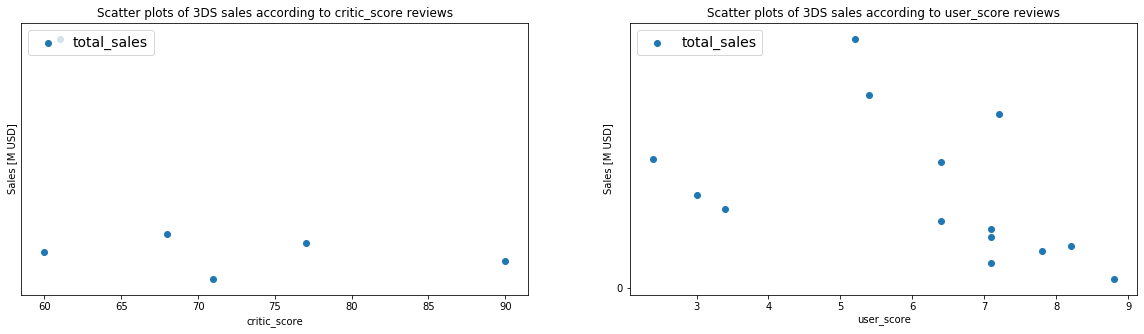


Correlation between critic_score reviews and sales in XOne platform

na_sales        0.38
eu_sales        0.35
jp_sales        0.19
other_sales     0.40
total_sales     0.40
critic_score    1.00
Name: critic_score, dtype: float64

Correlation between user_score reviews and sales in XOne platform

na_sales      -0.11
eu_sales      -0.09
jp_sales       0.09
other_sales   -0.11
total_sales   -0.11
user_score     1.00
Name: user_score, dtype: float64


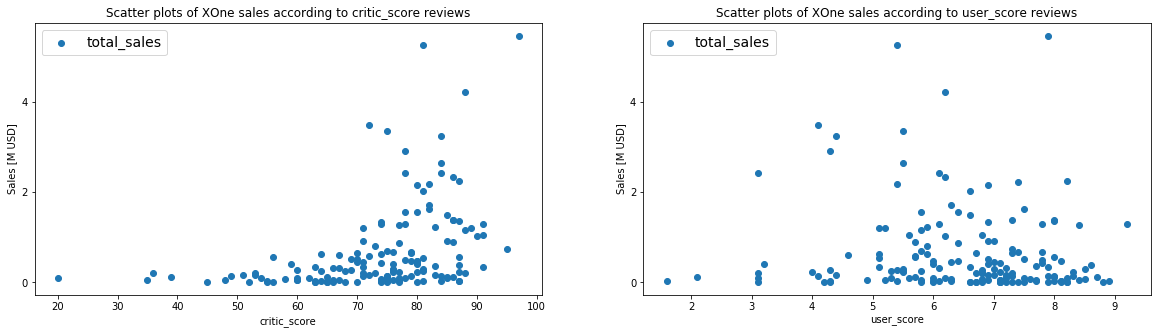


Correlation between critic_score reviews and sales in PS3 platform

na_sales        0.35
eu_sales        0.37
jp_sales        0.26
other_sales     0.38
total_sales     0.37
critic_score    1.00
Name: critic_score, dtype: float64

Correlation between user_score reviews and sales in PS3 platform

na_sales      -0.01
eu_sales       0.00
jp_sales       0.17
other_sales    0.03
total_sales    0.01
user_score     1.00
Name: user_score, dtype: float64


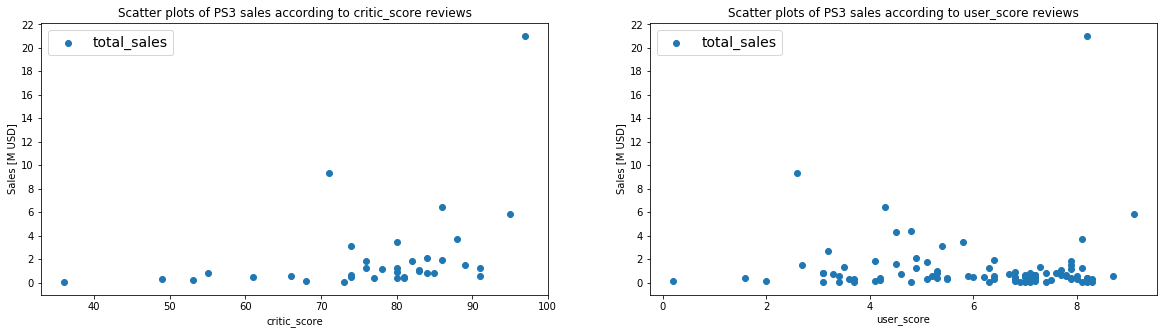


Correlation between critic_score reviews and sales in X360 platform

na_sales        0.33
eu_sales        0.34
jp_sales        0.14
other_sales     0.34
total_sales     0.34
critic_score    1.00
Name: critic_score, dtype: float64

Correlation between user_score reviews and sales in X360 platform

na_sales      -0.06
eu_sales      -0.04
jp_sales       0.00
other_sales   -0.06
total_sales   -0.06
user_score     1.00
Name: user_score, dtype: float64


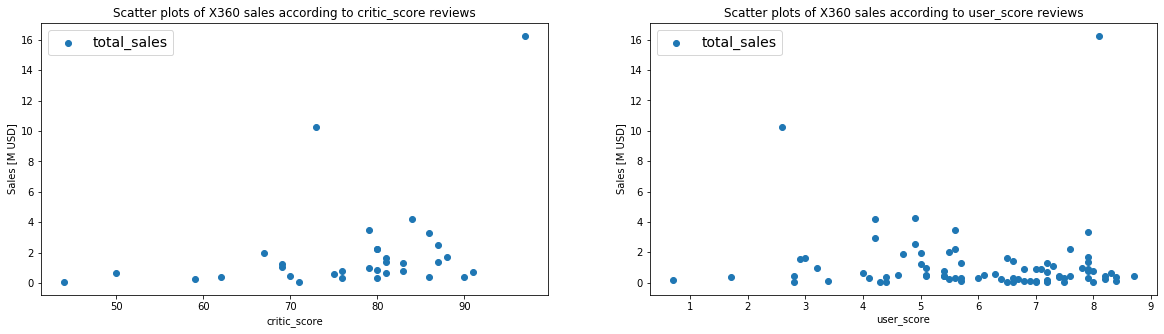

In [551]:
#comparing the sales of the same games in other platforms (year of release 2012-2016)

PS4_games = list(data.loc[(relevant_mask) & (data['platform']=='PS4'),'name'].unique())
for platform in (set(platforms_new) - set(['PS4'])):
    fig, axs = plt.subplots(1,2,figsize=(20,5))
    i=0
    for review in ['critic_score', 'user_score']:
        axs[i].set_title('Scatter plots of ' + platform + ' sales according to '+review + ' reviews')
        axs[i].set(xlabel=review,ylabel='Sales [M USD]')
        axs[i].scatter(x=data.loc[(relevant_mask) & (data[review]>=0)& (data['platform']==platform) \
                                  & (data['name'].isin(PS4_games)),review], 
                       y=data.loc[(relevant_mask) & (data[review]>=0)& (data['platform']==platform) \
                                  & (data['name'].isin(PS4_games)),'total_sales'],
                      label='total_sales')
        axs[i].legend(loc='upper left', fontsize=14);

        #set y precision
            #ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))
        axs[i].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
            # these are matplotlib.patch.Patch properties
        i+=1
        print('\nCorrelation between',review, 'reviews and sales in '+platform+' platform\n')
        print(data.loc[(relevant_mask) & (data[review]>=0) & (data['platform']==platform) \
                   & (data['name'].isin(PS4_games)), \
         ['na_sales','eu_sales','jp_sales','other_sales','total_sales',review]].corr().round(2) \
          [review])
    plt.show()
#    print('Correlation between professional reviews and sales in '+platform+' platform\n')
#    print(data.loc[(relevant_mask) & (data['critic_score']>=0) & (data['platform']==platform) \
#                   & (data['name'].isin(PS4_games)), \
#         ['na_sales','eu_sales','jp_sales','other_sales','total_sales','critic_score']].corr().round(2) \
#          ['critic_score'])
#    print('\nCorrelation between user reviews and sales in '+platform+' platform\n')
#    print(data.loc[(relevant_mask) & (data['user_score']>=0) & (data['platform']==platform) \
#                   & (data['name'].isin(PS4_games)), \
#         ['na_sales','eu_sales','jp_sales','other_sales','total_sales','user_score']].corr().round(2) \
#     ['user_score'])

- 3DS has a small data regarding the PS4 games, only 6 professional reviews. Thus we can't tell much from the graphs or correlations, both are negative around -0.45.
- XOne graphs look similar to those of PS4 with similar correlation in professional review of 0.4, but negative -0.11 in user review. The similarity makes sense because in the plots by year of release we saw that PS4 and XOne share the timing and sales pattern.
- PS3, X360 has similar correlations to PS4 but we can't tell much from the graphs as the data is small.

Text(0.5, 1.0, 'Number of games per genre in the years of release 2012-2016')

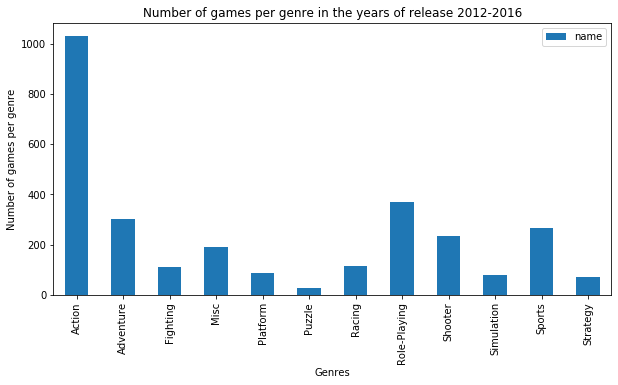

In [552]:
#games distribution by genre in the years of release 2012-2016

games_by_genres = data.loc[relevant_mask,:].pivot_table(index='genre',values='name',aggfunc='count')
genres = list(games_by_genres.index)
ax = games_by_genres.plot.bar(figsize=(10,5))
ax.set(xlabel='Genres',ylabel='Number of games per genre')
ax.set_title('Number of games per genre in the years of release 2012-2016')



Action is the top genre with much more games released than other genres (more than 1000 in the past 5 years).
Other popular genres are Role-Playing, Adventure, sports and shooter (up to 400 releases)

We can assume that games companies choose to release more games in some categories because they sell better, therefore we can generallize that Action has the highest sales, and Puzzle the lowest.

Text(0.5, 1.0, 'Total sales per genre in the years of release 2012-2016')

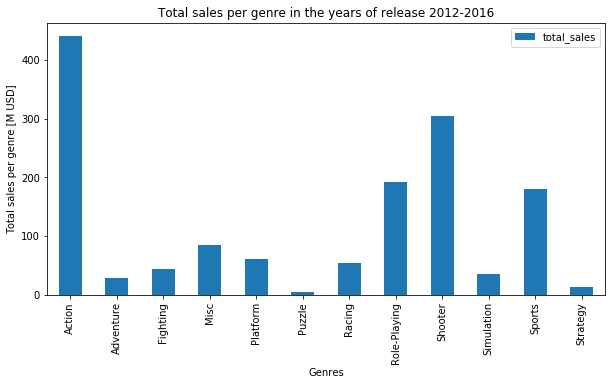

In [553]:
#Sales distribution by genre in the years of release 2012-2016

sales_by_genres = data.loc[relevant_mask,:].pivot_table(index='genre',values='total_sales',aggfunc='sum')
genres = list(sales_by_genres.index)
ax = sales_by_genres.plot.bar(figsize=(10,5))
ax.set(xlabel='Genres',ylabel='Total sales per genre [M USD]')
ax.set_title('Total sales per genre in the years of release 2012-2016')


Action is in the top sales and Puzzle is in the bottom. But sales of other popular genres are not completely predictable (shooter leads, adventure have low sales)

## Creating a user profile for each region

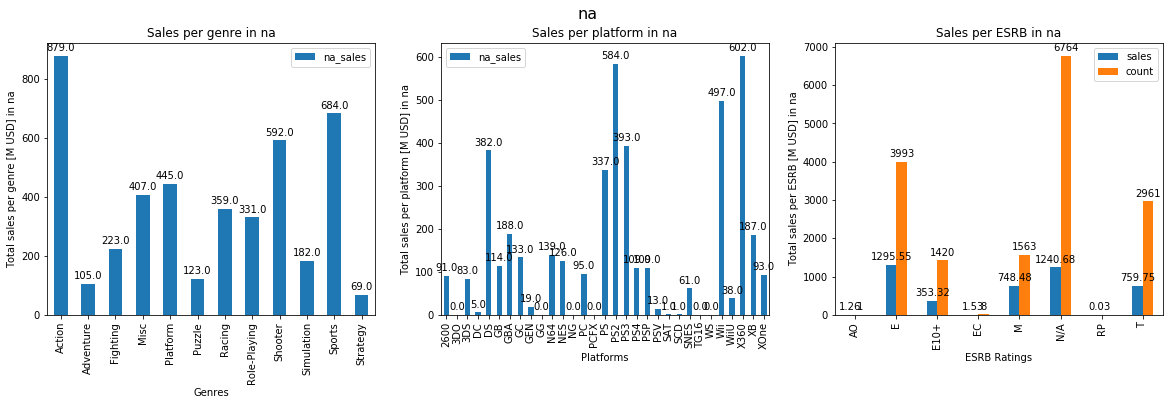

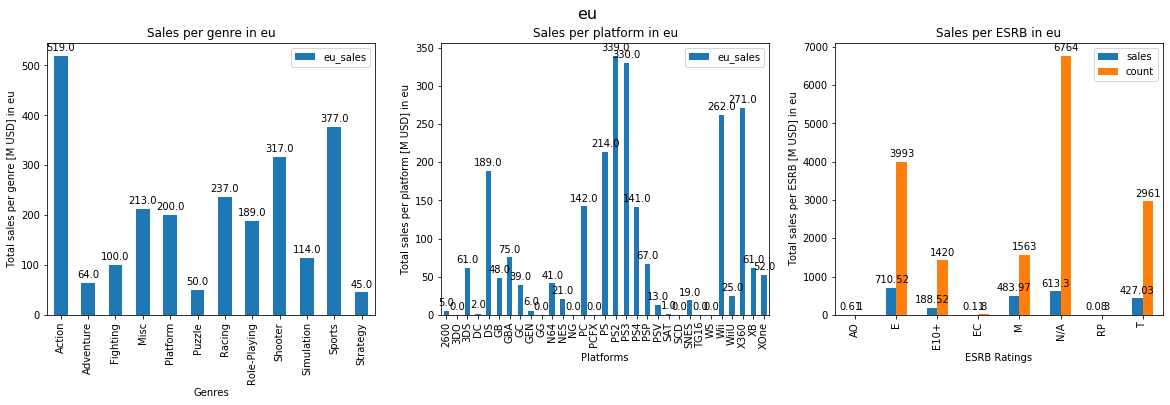

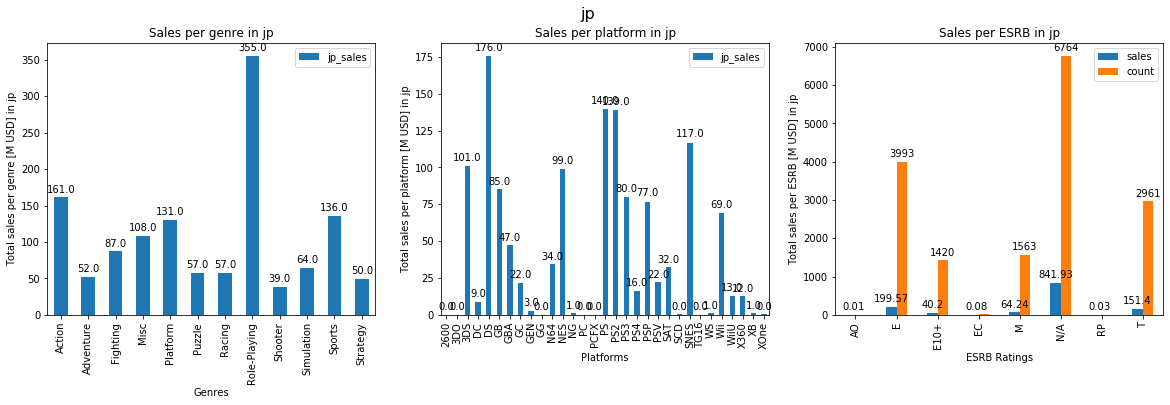

In [554]:
# ragional sales distributions per platform,genre

for reg in ['na', 'eu', 'jp']:
    #calculating the sales per genre,platform
    sales_by_genres = data.pivot_table(index='genre',values=reg+'_sales',aggfunc='sum')
    genres = list(sales_by_genres.index)
    sales_by_platform = data.pivot_table(index='platform',values=reg+'_sales',aggfunc='sum')
    platforms = list(sales_by_platform.index)
    sales_by_rating = data.pivot_table(index='rating',values=reg+'_sales',aggfunc=['sum','count'])
    sales_by_rating.columns = ['sales','count']
    sales_by_rating['relative_sales']= sales_by_rating['sales'].divide(sales_by_rating['count'])
    ratings = list(sales_by_rating.index)
    #bar plotting
    fig, axs = plt.subplots(1,3,figsize=(20,5))
    fig.suptitle(reg, fontsize=16)
    genre_ax = sales_by_genres.plot.bar(ax=axs[0])
    axs[0].set(xlabel='Genres',ylabel='Total sales per genre [M USD] in '+reg)
    axs[0].set_title('Sales per genre in '+reg)
    plat_ax = sales_by_platform.plot.bar(ax=axs[1])
    axs[1].set(xlabel='Platforms',ylabel='Total sales per platform [M USD] in '+reg)
    axs[1].set_title('Sales per platform in '+reg)    
    rate_ax = sales_by_rating.plot.bar(y=['sales','count'],ax=axs[2])
    axs[2].set(xlabel='ESRB Ratings',ylabel='Total sales per ESRB [M USD] in '+reg)
    axs[2].set_title('Sales per ESRB in '+reg)  
    #labeling bars values
    for rect in genre_ax.containers[0]:
        height = round(rect.get_height())
        axs[0].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    for rect in plat_ax.containers[0]:
        height = round(rect.get_height())
        axs[1].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
    for bar in rate_ax.containers:
        for rect in bar:
            height = round(rect.get_height(),2)
            axs[2].annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom') 
    
        
    plt.show()

Top five platforms:

NA: X360 (602M), PS2, Wii, PS3, DS 

EU: PS2 (339M), PS3, X360, Wii, PS 

JP: DS (176M), PS, PS2, SNES, 3DS

The sales of platforms are quite similar for NA and EU. NA like X360 better and EU like PS2,PS3.
JP on the other hand don't use much X360 relatively, they preffered DS,PS over the years. They also bought a lot of Wii games but it's not in the top five.
Anyway These are distributions for all the range of years since 1985 and they don't say much about recent years.

Top five genres:

NA: Action (879M), Sports, Shooter, Platform, Misc

EU: Action (519M), Sports, Shooter, Racing, Misc

JP: Role-Playing (355M), Action, Sports, Platform, Misc

Genre sales are quite similar for NA,EU. JP bought more Role-Playing games with a significant difference. The rest of their preferences are similar to NA and EU.

ESRB Rating:
Remembering only about 50% of games have ratings, in all regions games for everyone 'E' sell the most, but that's also due to the fact there are more 'E' games than others.
In NA and EU mature games 'M' sell more relative to the amount of games.
It looks like ESRB rating doesn't have a big influence on sales.

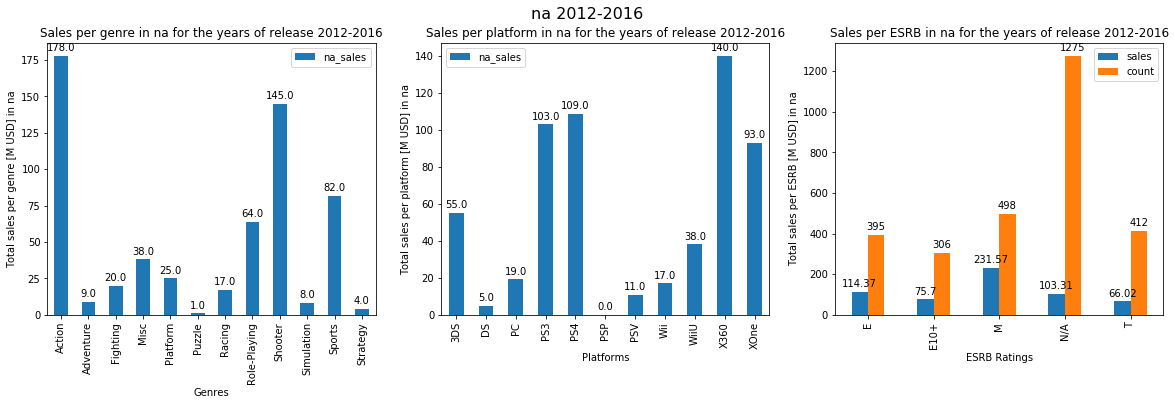

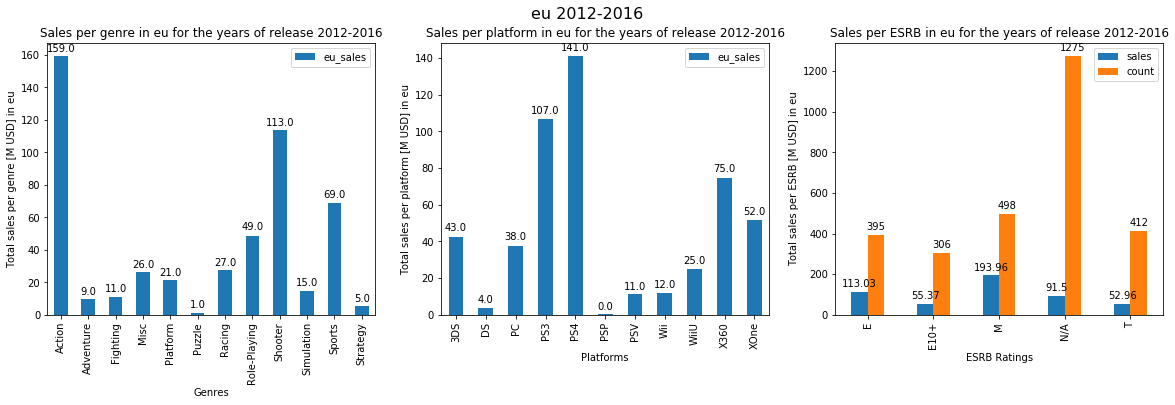

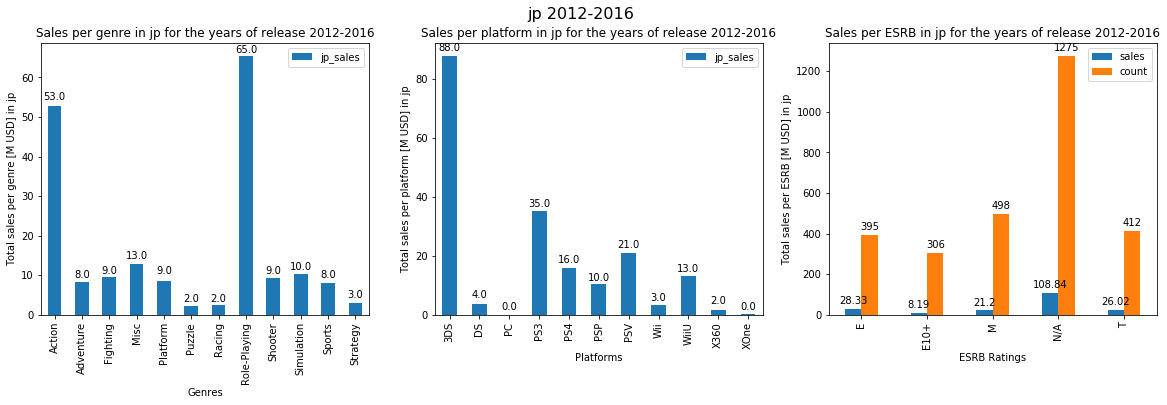

In [555]:
# ragional sales distributions per platform,genre for the years of release 2012-2016

for reg in ['na', 'eu', 'jp']:
    #calculating the sales per genre,platform
    sales_by_genres = data[relevant_mask].pivot_table(index='genre',values=reg+'_sales',aggfunc='sum')
    genres = list(sales_by_genres.index)
    sales_by_platform = data[relevant_mask].pivot_table(index='platform',values=reg+'_sales',aggfunc='sum')
    platforms = list(sales_by_platform.index)
    sales_by_rating = data[relevant_mask].pivot_table(index='rating',values=reg+'_sales',aggfunc=['sum','count'])
    sales_by_rating.columns = ['sales','count']
    sales_by_rating['relative_sales']= sales_by_rating['sales'].divide(sales_by_rating['count'])
    ratings = list(sales_by_rating.index)
    #bar plotting
    fig, axs = plt.subplots(1,3,figsize=(20,5))
    fig.suptitle(reg+' 2012-2016', fontsize=16)
    genre_ax = sales_by_genres.plot.bar(ax=axs[0])
    axs[0].set(xlabel='Genres',ylabel='Total sales per genre [M USD] in '+reg)
    axs[0].set_title('Sales per genre in '+reg+' for the years of release 2012-2016')
    plat_ax = sales_by_platform.plot.bar(ax=axs[1])
    axs[1].set(xlabel='Platforms',ylabel='Total sales per platform [M USD] in '+reg)
    axs[1].set_title('Sales per platform in '+reg+' for the years of release 2012-2016')    
    rate_ax = sales_by_rating.plot.bar(y=['sales','count'],ax=axs[2])
    axs[2].set(xlabel='ESRB Ratings',ylabel='Total sales per ESRB [M USD] in '+reg)
    axs[2].set_title('Sales per ESRB in '+reg+' for the years of release 2012-2016')     
    #labeling bars values
    for rect in genre_ax.containers[0]:
        height = round(rect.get_height())
        axs[0].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    for rect in plat_ax.containers[0]:
        height = round(rect.get_height())
        axs[1].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    for bar in rate_ax.containers:
        for rect in bar:
            height = round(rect.get_height(),2)
            axs[2].annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')    
   
    plt.show()

Top five platforms in the years of release 2012-2016:

NA: X360 (140M), PS4, PS3, XOne, 3DS 

EU: PS4 (141M), PS3, X360,  XOne, 3DS 

JP: 3DS (88M), PS3, PSV, PS4, WiiU

NA and EU have the same top five, but NA preffer X360 while EU preffer PS4. JP top platform is 3DS in a significant difference from others. 

Top five genres:

NA: Action (178M),  Shooter, Sports, Role-Playing, Misc

EU: Action (159M),  Shooter, Sports, Role-Playing, Racing

JP: Role-Playing (65M), Action, Misc, Simulation, Platform, Shooter, Fighting

Genre sales are quite similar for NA,EU. JP bought more Role-Playing games with a significant difference, right after is Action games. Sports didn't reach the top five.

ESRB Rating:
In NA and EU mature games 'M' are leading the sales, and also relatively to their number.
In JP 'E' is still leading.

## Testing hypotheses

#### Average user ratings of the Xbox One and PC platforms are the same

Null hypotheses H0: mean of user ratings of the XOne platform equals mean of user ratings of PC platform
Alternative H1: mean of user ratings of the XOne platform isn't equal mean of user ratings of PC platform

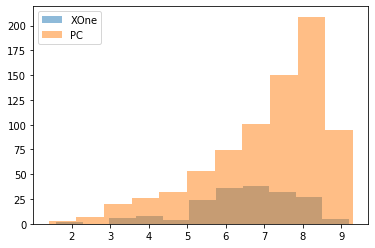

In [556]:
#plotting hists
fig,ax = plt.subplots()
XOne_user = data.loc[(data['platform']=='XOne') & (data['user_score']>=0),'user_score']
PC_user = data.loc[(data['platform']=='PC') & (data['user_score']>=0),'user_score']
ax.hist(XOne_user,bins=11, alpha=0.5, label='XOne')
ax.hist(PC_user, bins=11, alpha=0.5, label='PC')
plt.legend(loc='upper left')

The samples are skewed, therefore I'll use levene test with median to test variances equality, with alpha=0.001

In [557]:
#levene test for variances 
alpha=0.001

results=stats.levene(XOne_user,PC_user)
print('p-value:',results.pvalue)
if (results.pvalue < alpha):
    print("We reject the null hypothesis that variances are equal")
else:
    print("We can't reject the null hypothesis that variances are equal")

p-value: 0.2693951512047048
We can't reject the null hypothesis that variances are equal


In order to ttest H0 I'll use equal variances.
Choosing alpha:
Previously when looked on total sales vs user rating I found that for most cases the correlation is nearly 0, the only exception was JP with a minor correlation. Therefore I wouldn't reccomend to use user rating in the sales prognosis anyway. But if someone is going to use it, it's more important to avoid false positive - not reject H0 when in reality it's wrong, because then one might forecast similar sales on platforms that in reality don't behave the same, and then to put similar resources on the platforms and lose money he could have made focusing on the leading platform.

I chose alpha=0.1

In [558]:
#ttesing H0
alpha = 0.1

results = stats.ttest_ind(XOne_user,PC_user, equal_var=True)# assume equal population variance

print('p-value:',results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 1.3896435533548819e-05
We reject the null hypothesis


p values is extremly small and we can safely reject H0 and work with H1.

#### Average user ratings for the Action and Sports genres are different.

Null hypotheses H0: mean of user ratings of the Action genre equals mean of user ratings of Sports genre
Alternative H1: mean of user ratings of the Action genre isn't equal mean of user ratings of Sports genre

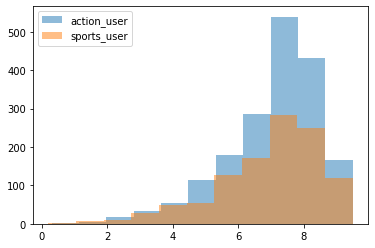

In [559]:
#plotting hists
fig,ax = plt.subplots()
action_user = data.loc[(data['genre']=='Action') & (data['user_score']>=0),'user_score']
sports_user = data.loc[(data['genre']=='Sports') & (data['user_score']>=0),'user_score']
ax.hist(action_user,bins=11, alpha=0.5, label='action_user')
ax.hist(sports_user, bins=11, alpha=0.5, label='sports_user')
plt.legend(loc='upper left')

The samples are skewed, therefore I'll use levene test with median to test variances equality, with alpha=0.001

In [560]:
#levene test for variances 
alpha=0.001

results=stats.levene(action_user,sports_user)
print('p-value:',results.pvalue)
if (results.pvalue < alpha):
    print("We reject the null hypothesis that variances are equal")
else:
    print("We can't reject the null hypothesis that variances are equal")

p-value: 0.0001736640672727649
We reject the null hypothesis that variances are equal


In order to ttest H0 I'll use inequal variances.
Choosing alpha:
As before, user rating is not so important but it's better to avoid false positive. I chose alpha=0.1

In [561]:
#ttesing H0
alpha = 0.1

results = stats.ttest_ind(XOne_user,PC_user, equal_var=False)# assume inequal population variance

print('p-value:',results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 4.935072360183565e-06
We reject the null hypothesis


p values is extremly small and we can safely reject H0 and work with H1.

## Conclusion

Insights for building a prognosis for 2017:
- There was a significant change in number of releases behaviour in the year of financial crisis 2008, so it's better to examine data after 2008
- The "living period" of a platform is about 10 years 
- when sales on a platform start to drop it takes no more than a year for a new platform to appear
- Since 2016 the sales on the various platforms are decreasing
- Although some games sales exceeded 10M, the majority of sales are less than 1M
- Professional ratings have moderate influence on sales, user ratings have almost no influence
- Action is by far the most prevalent genre, and, accordinly, the leading genre in global sales
- ESRB rating has a minor influence on sales. Over the years 'Everyone' games sold more but were also more common. In the past 5 years 'Mature' sell more in NA and EU, in JP it's still 'Everyone'
- Users from NA and EU have similar preferences regarding games genres and platforms
- Action-Sports-Shooter kinds lead the sales in NA, EU and are also popular in JP, and in the past 5 years we can see a decrease in other platforms sales, the popular ones are getting more popular and total sales drop.
- Role-Playing is the most popular in JP, and in the past 5 years it also became quite popular in NA,EU, while Action sales increased in JP

I would advice to prepare for a new platform, and to a continued decrease in overall releases and sales of games.
As sales drop, the user preferences are becoming more specific towards certain genres (Action, Shooter in NA,EU with 'Mature' rating, and Role-Playing,Action in JP). It's better to forecast separately for NA-EU and JP.